In [2]:
!pip install spacy

In [4]:
!pip install pyLDAvis

  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97717 sha256=a33dfc0ca9720a6de5a45f7706a9b5a48565c11160b8bacdf6a575ea16e6bfbb
  Stored in directory: c:\users\s4517002\appdata\local\pip\cache\wheels\3b\fb\41\e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32047 sha256=8f50a1a6e0c196242d30993f6ba89cb0ebeca44427ab668fdb65677518e97baf
  Stored in directory: c:\users\s4517002\appdata\local\pip\cache\wheels\3c\33\97\805b282e129f60bb4e87cea622338f30b65f21eaf65219971f
Successfully built pyLDAvis funcy


In [5]:
import re
import pandas as pd
from collections import defaultdict
import operator
from pprint import pprint

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [16]:
df = pd.read_csv("brisbanecovidkeyword_merge.csv",index_col=0)

In [17]:
df

date         username              to  replies  retweets  \
0     2020-09-01 23:49:26  VikingCapitalGr             NaN        0         0   
1     2020-09-01 23:35:52       RMorrison9             NaN        0         0   
2     2020-09-01 23:33:00   Chopsie_Murphy  jenniegannaway        1         0   
3     2020-09-01 23:14:39    poppymasselos             NaN        0         0   
4     2020-09-01 23:07:37    litecoin_bull      yogini0208        2         0   
...                   ...              ...             ...      ...       ...   
1543  2020-02-23 10:20:01            SGM63   audiocomedian        2         0   
1544  2020-02-15 00:21:39       sanjeev_mh             NaN        0         0   
1545  2020-02-13 08:30:21        murdochsj             NaN        0         1   
1546  2020-02-12 23:08:27       sanjeev_mh          RT_com        1         1   
1547  2020-02-08 14:52:37          denujak         wcrfint        0         7   

      favorites                                               text  geo  \
0             0  Profit reporting season is over with the coron...  NaN   
1             3  Bikie Shane Bowden did NOT have coronavirus an...  NaN   
2             1  The minister can extend the period of the coro...  NaN   
3             0  'Health dictatorship': Tony Abbott rails again...  NaN   
4             5  we understand, but in the end, it will be wort...  NaN   
...         ...                                                ...  ...   
1543          1  It seems bizarre that he is saying a pandemic ...  NaN   
1544          0  @WHO should seek official position of all #Nat...  NaN   
1545          4  Yarn alert: Hong Kong banks compare pandemic s...  NaN   
1546          0  Societies at the moment seem to be stumbling o...  NaN   
1547          9  Obesity is a global pandemic #Obesity itself i...  NaN   

           mentions                                           hashtags  \
0               NaN                                                NaN   
1     @AnnastaciaMP                                                NaN   
2               NaN                                                NaN   
3               NaN                                                NaN   
4               NaN                                                NaN   
...             ...                                                ...   
1543            NaN                                                NaN   
1544       @WHO @UN  #Nations #prepared #COVID2019 #pandemic #dorma...   
1545            NaN                                                NaN   
1546            NaN  #thin #ice #faith #hope #capacity #mega #scale...   
1547       @IMBatUQ                              #Obesity #WomenInSTEM   

                       id                                          permalink  
0     1300943883094769664  https://twitter.com/VikingCapitalGr/status/130...  
1     1300940469484965888  https://twitter.com/RMorrison9/status/13009404...  
2     1300939747712356352  https://twitter.com/Chopsie_Murphy/status/1300...  
3     1300935128017846272  https://twitter.com/poppymasselos/status/13009...  
4     1300933357413363712  https://twitter.com/litecoin_bull/status/13009...  
...                   ...                                                ...  
1543  1231524104982786048  https://twitter.com/SGM63/status/1231524104982...  
1544  1228474417694437376  https://twitter.com/sanjeev_mh/status/12284744...  
1545  1227872625562726401  https://twitter.com/murdochsj/status/122787262...  
1546  1227731219078504448  https://twitter.com/sanjeev_mh/status/12277312...  
1547  1226156885650202630  https://twitter.com/denujak/status/12261568856...  

[8528 rows x 12 columns]

In [18]:
def preprocess_df(df):
    date = df['date']
    df['date'] = pd.to_datetime(date)
    df['only_date'] =df['date'].dt.date
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['month']
    df(['username','to','favorites','mentions','permalink'],axis = 1)

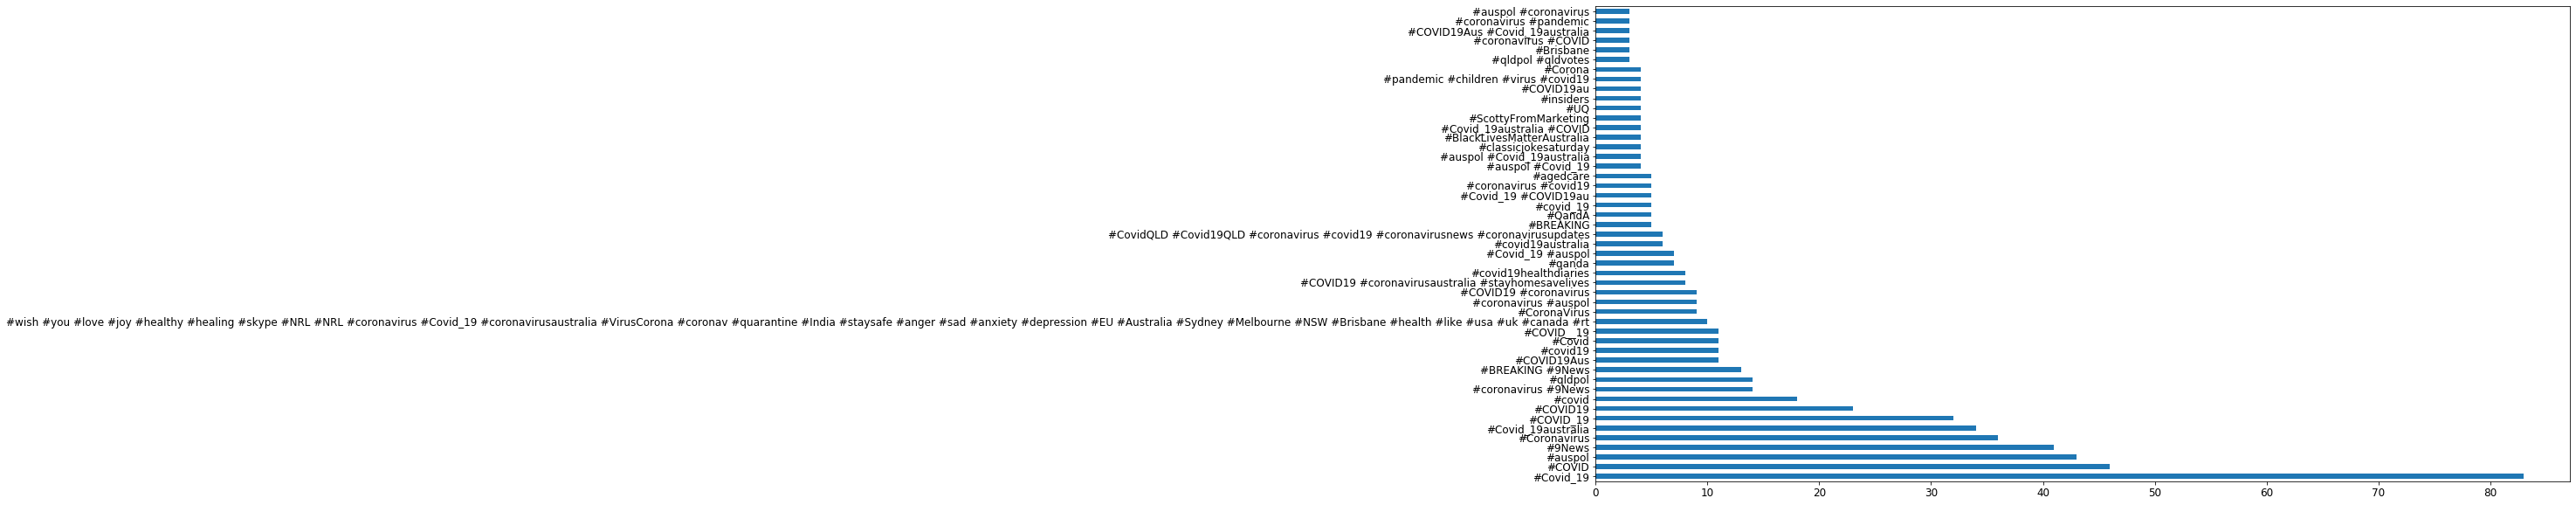

In [13]:
import matplotlib.pyplot as plt
df['hashtags'].value_counts()[1:50].plot(kind='bar', figsize=(20, 10), fontsize=12)

In [23]:
#load libraries required for data preprocessing 
import nltk
import re
from collections import defaultdict
from gensim import corpora, models, similarities
from nltk.tokenize import RegexpTokenizer
from string import digits

In [26]:
#derive the 'month' attribute and use the month and full text attributes as features
subtweetsDF = df[['text', 'month']]

In [28]:
#aggregate tweets by the creation month 
subtweetsDF.month=subtweetsDF.month.astype(str)
subtweetsDict = subtweetsDF.groupby('month')['text'].apply(list).to_dict()
print("No of documents before data preprocessing: %d" % len(subtweetsDict.keys()))
#1st-level filtration & merge lists of tweets into string attributes
filtered1stsubtweetsDict = {}
for k in subtweetsDict.keys():
    if len(subtweetsDict[k]) >= 10:
        filtered1stsubtweetsDict[k] = " ".join(subtweetsDict[k])
print("No of documents after 1st-level filtration: %d" % len(filtered1stsubtweetsDict.keys()))
#remove URLs
for k in filtered1stsubtweetsDict.keys():
    filtered1stsubtweetsDict[k] = re.sub(r"(?:\@|http?\://)\S+", "", filtered1stsubtweetsDict[k])
#2nd-level filtration
filtered2ndsubtweetsDict = {}
for k in filtered1stsubtweetsDict.keys():
    if len(filtered1stsubtweetsDict[k]) >= 1000:
        filtered2ndsubtweetsDict[k] = filtered1stsubtweetsDict[k]
print("No of documents after 2nd-level filtration: %d" % len(filtered2ndsubtweetsDict.keys()))
#tokenize
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
for k in filtered2ndsubtweetsDict.keys():
    filtered2ndsubtweetsDict[k] = tokenizer.tokenize(filtered2ndsubtweetsDict[k].lower())
#remove stopwords and statistically insignificant tokens
stoplist_tw=['amp','get','got','hey','hmm','hoo','hop','iep','let','ooo','par',
            'pdt','pln','pst','wha','yep','yer','aest','didn','nzdt','via',
            'one','com','new','like','great','make','top','awesome','best',
            'good','wow','yes','say','yay','would','thanks','thank','going',
            'new','use','should','could','best','really','see','want','nice',
            'while','know','https']
unigrams = list(set([ w for doc in filtered2ndsubtweetsDict.values() for w in doc if len(w)==1]))
bigrams  = list(set([ w for doc in filtered2ndsubtweetsDict.values() for w in doc if len(w)==2]))
stoplist  = set(nltk.corpus.stopwords.words("english") + stoplist_tw + unigrams + bigrams)
for k in filtered2ndsubtweetsDict.keys():
    filtered2ndsubtweetsDict[k] = [token for token in filtered2ndsubtweetsDict[k] if token not in stoplist]
#remove words that only occur once
token_frequency = defaultdict(int)
for doc in filtered2ndsubtweetsDict.values():
    for token in doc:
        token_frequency[token] += 1
for k in filtered2ndsubtweetsDict.keys():
    filtered2ndsubtweetsDict[k] = [token for token in filtered2ndsubtweetsDict[k] if token_frequency[token] > 1]
# Sort tokens in documents
for k in filtered2ndsubtweetsDict.keys():
    filtered2ndsubtweetsDict[k].sort()
#build a dictionary for all documents as well as for each month
dictionaries = {}
dictionaries['all'] = corpora.Dictionary(filtered2ndsubtweetsDict.values())
dictionaries['all'].compactify()
for k in filtered2ndsubtweetsDict.keys():
    dictionaries[k] = corpora.Dictionary([filtered2ndsubtweetsDict[k]])
    dictionaries[k].compactify()
print("There are %d unique tokens in the dictionary of all documents." % len(dictionaries['all'].values()))
#build a corpus for all documents as well as for each month
corpora = {}
corpora['all'] = [dictionaries['all'].doc2bow(doc) for doc in filtered2ndsubtweetsDict.values()]
for k in filtered2ndsubtweetsDict.keys():
    corpora[k] = [dictionaries[k].doc2bow(filtered2ndsubtweetsDict[k])]

No of documents before data preprocessing: 8
No of documents after 1st-level filtration: 8
No of documents after 2nd-level filtration: 8
There are 8492 unique tokens in the dictionary of all documents.


In [29]:
#select hyperparameters
lda_params = {'num_topics': 20, 'passes': 10, 'alpha': 0.01}
print("Training LDA models with: %s  " % lda_params)

Training LDA models with: {'num_topics': 20, 'passes': 10, 'alpha': 0.01}  


In [30]:
#train LDA models for all documents as well as for each month
LDAs = {}
for k in corpora.keys():
    LDAs[k] = models.LdaModel(corpora[k], 
                    id2word=dictionaries[k],
                    num_topics=lda_params['num_topics'],
                    passes=lda_params['passes'],
                    alpha = lda_params['alpha'])

In [31]:
import pyLDAvis.gensim

In [32]:
#the keys of all the LDA models we have trained in the modelling phase
LDAs.keys()

dict_keys(['all', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09'])

In [33]:
all_docs_topics =  pyLDAvis.gensim.prepare(LDAs['all'], corpora['all'], dictionaries['all'])
pyLDAvis.display(all_docs_topics)

In [34]:
month = '2020-02'
month_topics =  pyLDAvis.gensim.prepare(LDAs[month], corpora[month], dictionaries[month])
pyLDAvis.display(month_topics)

In [75]:

from nltk.corpus import stopwords

def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    return tweet


In [50]:
text = df['text'].tolist()
sentences_as_one_string = " ".join(text)

In [66]:
data_words = gensim.utils.simple_preprocess(str(sentences_as_one_string), deacc=True)  # deacc=True removes punctuations
print(data_words)

['profit', 'reporting', 'season', 'is', 'over', 'with', 'the', 'coronavirus', 'recession', 'driving', 'results', 'bikie', 'shane', 'bowden', 'did', 'not', 'have', 'coronavirus', 'and', 'was', 'not', 'infectious', 'when', 'he', 'flew', 'from', 'melbourne', 'to', 'victoria', 'on', 'monday', 'why', 'queensland', 'authorities', 'repeatedly', 'said', 'he', 'was', 'covid', 'even', 'this', 'morning', 'by', 'annastaciamp', 'is', 'unclear', 'story', 'https', 'www', 'news', 'com', 'au', 'national', 'coronavirus', 'victoria', 'former', 'bikie', 'queensland', 'flight', 'brisbane', 'infection', 'confusion', 'health', 'alert', 'jetstar', 'passengers', 'covid', 'ab', 'the', 'minister', 'can', 'extend', 'the', 'period', 'of', 'the', 'coronavirus', 'supplement', 'via', 'legislative', 'instrument', 'the', 'supplement', 'is', 'firmly', 'sitting', 'in', 'the', 'lnp', 'court', 'amp', 'alp', 'is', 'not', 'barred', 'from', 'protest', 'vote', 'with', 'the', 'greens', 'people', 'are', 'tired', 'of', 'them', 's

In [71]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words]])

['profit', 'reporting', 'season', 'is', 'over', 'with', 'the', 'coronavirus', 'recession', 'driving', 'results', 'bikie', 'shane', 'bowden', 'did', 'not', 'have', 'coronavirus', 'and', 'was', 'not', 'infectious', 'when', 'he', 'flew', 'from', 'melbourne', 'to', 'victoria', 'on', 'monday', 'why', 'queensland', 'authorities', 'repeatedly', 'said', 'he', 'was', 'covid', 'even', 'this', 'morning', 'by', 'annastaciamp', 'is', 'unclear', 'story', 'https', 'www', 'news', 'com', 'au', 'national', 'coronavirus', 'victoria', 'former', 'bikie', 'queensland', 'flight', 'brisbane', 'infection', 'confusion', 'health', 'alert', 'jetstar', 'passengers', 'covid', 'ab', 'the', 'minister', 'can', 'extend', 'the', 'period', 'of', 'the', 'coronavirus', 'supplement', 'via', 'legislative', 'instrument', 'the', 'supplement', 'is', 'firmly', 'sitting', 'in', 'the', 'lnp', 'court', 'amp', 'alp', 'is', 'not', 'barred', 'from', 'protest', 'vote', 'with', 'the', 'greens', 'people', 'are', 'tired', 'of', 'them', 's

In [81]:
!pip3 install -U spacy 
!python3 -m spacy download en_core_web_sm 

  Using cached spacy-2.3.2-cp37-cp37m-win_amd64.whl (9.3 MB)
  Using cached blis-0.4.1-cp37-cp37m-win_amd64.whl (5.0 MB)
  Using cached thinc-7.4.1-cp37-cp37m-win_amd64.whl (2.0 MB)
  Using cached catalogue-1.0.0-py2.py3-none-any.whl (7.7 kB)
  Using cached cymem-2.0.3-cp37-cp37m-win_amd64.whl (32 kB)
  Using cached preshed-3.0.2-cp37-cp37m-win_amd64.whl (105 kB)
  Using cached srsly-1.0.2-cp37-cp37m-win_amd64.whl (179 kB)
  Using cached murmurhash-1.0.2-cp37-cp37m-win_amd64.whl (20 kB)
  Using cached plac-1.1.3-py2.py3-none-any.whl (20 kB)
  Using cached wasabi-0.8.0-py3-none-any.whl (23 kB)


You should consider upgrading via the 'c:\users\s4517002\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.
'python3' is not recognized as an internal or external command,
operable program or batch file.


In [84]:
!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz


  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.0-py3-none-any.whl size=12019125 sha256=f9bbc231fc0069ffc92b36b26e8eb851efabd07aae5b1b8d5b13bb8d5f2e2f03
  Stored in directory: c:\users\s4517002\appdata\local\pip\cache\wheels\64\69\41\6f820cf1d7488a0381a2059f66ec9f8f23116f7c67d18f3d8d
Successfully built en-core-web-sm


You should consider upgrading via the 'c:\users\s4517002\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [94]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [98]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load(nlp, disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized)

[['profit']]


In [99]:
print(data_lemmatized)

[['profit'], ['report'], ['season'], [], [], [], [], ['coronavirus'], ['recession'], ['drive'], ['result'], ['bikie'], ['shane'], ['bowden'], [], [], [], ['coronavirus'], [], [], [], ['infectious'], [], [], ['fly'], [], ['melbourne'], [], ['victoria'], [], ['monday'], [], ['queensland'], ['authority'], ['repeatedly'], ['say'], [], [], ['covid'], ['even'], [], ['morning'], [], ['annastaciamp'], [], ['unclear'], ['story'], ['https'], ['www'], ['news'], ['com'], ['au'], ['national'], ['coronavirus'], ['victoria'], ['former'], ['bikie'], ['queensland'], ['flight'], ['brisbane'], ['infection'], ['confusion'], ['health'], ['alert'], ['jetstar'], ['passenger'], ['covid'], ['ab'], [], ['minister'], [], ['extend'], [], ['period'], [], [], ['coronavirus'], ['supplement'], ['via'], ['legislative'], ['instrument'], [], ['supplement'], [], ['firmly'], ['sit'], [], [], ['lnp'], ['court'], ['amp'], ['alp'], [], [], ['bar'], [], ['protest'], ['vote'], [], [], ['greens'], ['people'], [], ['tired'], [],

In [ ]:
from LIS import 